# Next Pitch Prediction using LSTMs

The first series of tests will be carried out using basic LSTMs. An LSTM is a type of recurrent neural network that is capable of learning long-term dependencies. This is particularly useful for time series data, such as the pitch sequences in this dataset.

## Data loading and sequencing

In [1]:
import os
import tensorflow as tf
import keras_tuner

os.chdir('../..')
tf.keras.utils.set_random_seed(42)

In [2]:
from utils import preprocessing
from sklearn.model_selection import train_test_split

X, y_pitch, y_vertical, y_horizontal = preprocessing.get_sequences(os.path.join('data', 'raw', 'wade_miley.csv'))

# Split the data into training, validation, and testing sets
X_train, X_temp, y_pitch_train, y_pitch_temp, y_vertical_train, y_vertical_temp, y_horizontal_train, y_horizontal_temp = train_test_split(
    X, y_pitch, y_vertical, y_horizontal, test_size=0.4, random_state=54)

X_val, X_test, y_pitch_val, y_pitch_test, y_vertical_val, y_vertical_test, y_horizontal_val, y_horizontal_test = train_test_split(
    X_temp, y_pitch_temp, y_vertical_temp, y_horizontal_temp, test_size=0.5, random_state=42)

num_pitches = y_pitch.shape[1]
num_vertical_locs = y_vertical.shape[1]
num_horizontal_locs = y_horizontal.shape[1]

## Develop a model that does better than the baseline

In [3]:
def build_network(input_layer, num_targets, name='', num_hidden_units=128, num_hidden_layers=1, activation='tanh', recurrent_activation='sigmoid', reg=None, dropout=None):
    
    # Hidden layers
    x = input_layer
    for i in range(num_hidden_layers - 1):
        layer_name = f"{name}_hidden_{i+1}"
        if reg:
            x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True, kernel_regularizer=reg, name=layer_name)(x)
        else:
            x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=True, name=layer_name)(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout, name=f"{layer_name}_dropout")(x)
    
    # Last hidden layer without return_sequences
    layer_name = f"{name}_hidden_{num_hidden_layers}"
    if reg:
        x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=False, kernel_regularizer=reg, name=layer_name)(x)
    else:
        x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, recurrent_activation=recurrent_activation, return_sequences=False, name=layer_name)(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout, name=f"{layer_name}_dropout")(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=num_targets, activation='softmax', name=f'{name}_output')(x)

    return outputs

In [4]:
def build_model(hp):
    # Define the input layer
    input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch',
                         num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                         num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                         activation=hp.Choice('activation', values=['relu', 'elu', 'tanh', 'sigmoid']),
                         recurrent_activation=hp.Choice('recurrent_activation', values=['relu', 'elu', 'sigmoid', 'tanh']))
    vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical',
                          num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                          num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                          activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                          recurrent_activation=hp.Choice('recurrent_activation', values=['sigmoid', 'tanh']))
    horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal',
                            num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=5, step=1),
                            num_hidden_units=hp.Choice('num_hidden_units', values=[128, 256, 512]),
                            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                            recurrent_activation=hp.Choice('recurrent_activation', values=['sigmoid', 'tanh']))

    # Combine the models
    ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])
    # Compile the model
    ensemble_model.compile(optimizer='adam',
                      loss={'pitch_output': 'categorical_crossentropy',
                            'vertical_output': 'categorical_crossentropy',
                            'horizontal_output': 'categorical_crossentropy'},
                      metrics=['accuracy', 'accuracy', 'accuracy'])
    return ensemble_model

In [5]:
from utils.callbacks import FreezeOutputCallback

freeze_output_callback = FreezeOutputCallback(patience=5)

In [6]:
# Create an instance of the HyperParameters object
hp = keras_tuner.HyperParameters()

# Test the build_model function
model = build_model(hp)

# Train the model
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[freeze_output_callback],
                             verbose=0
                            )


Freezing output vertical at 13 epochs.

Freezing output pitch at 15 epochs.

Freezing output horizontal at 20 epochs.

All outputs frozen. Stopping training at epoch 20.


In [7]:
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - horizontal_output_accuracy: 0.5683 - loss: 4.0602 - pitch_output_accuracy: 0.4747 - vertical_output_accuracy: 0.6088
Pitch Test Accuracy: 0.5603099465370178
Vertical Test Accuracy: 0.47708895802497864
Horizontal Test Accuracy: 0.612533688545227


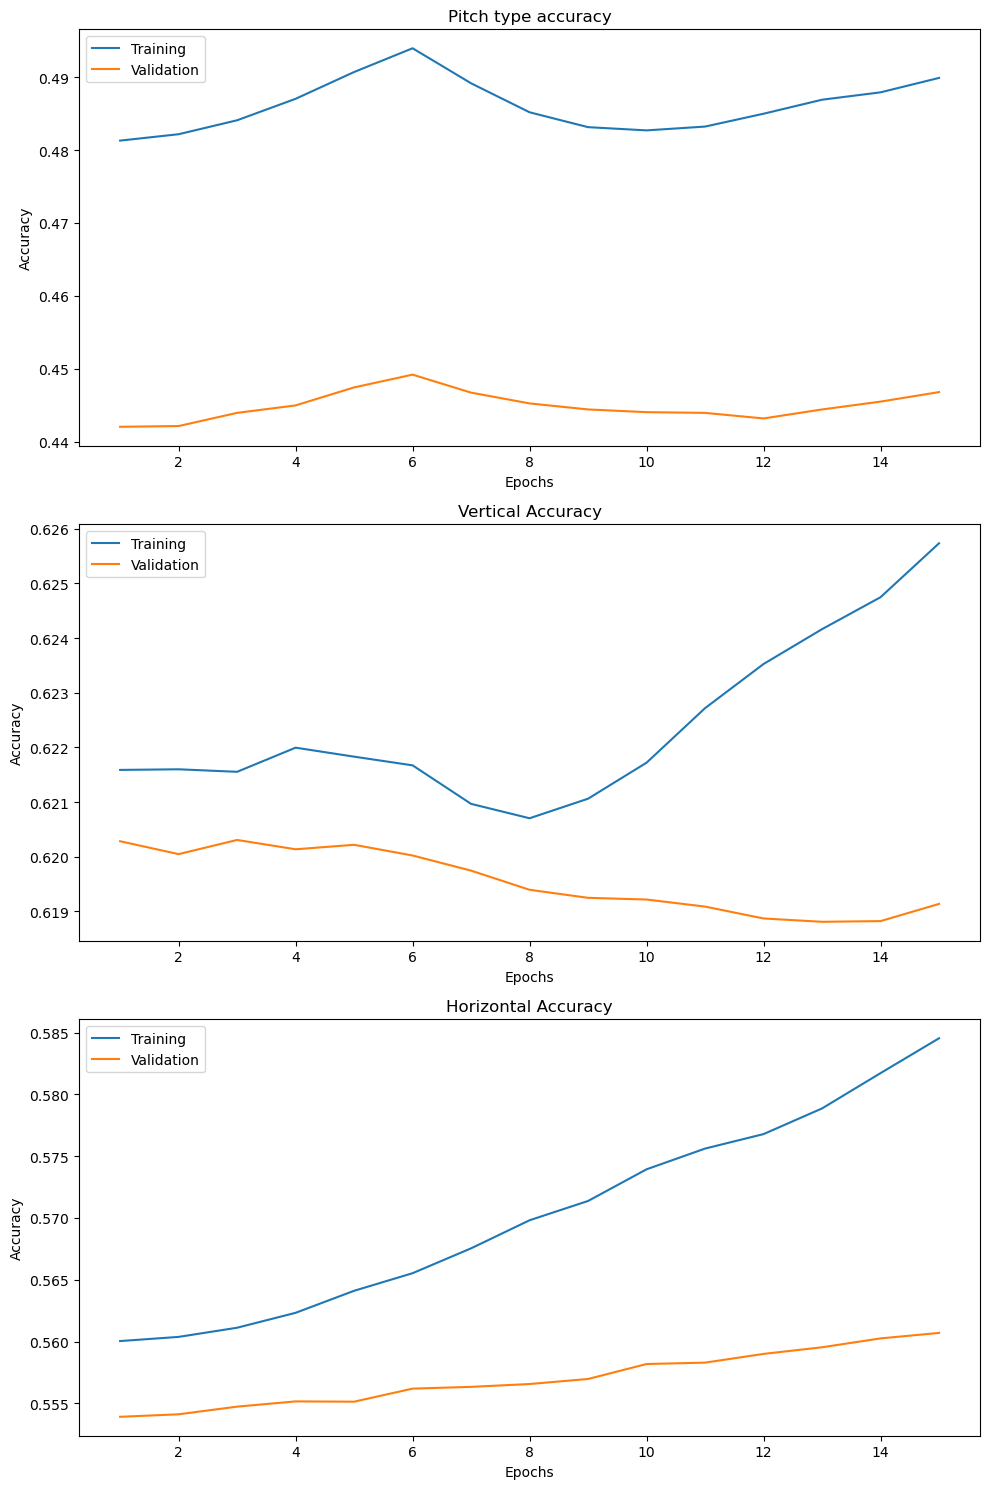

In [8]:
from utils.plot_utils import plot_ensemble_history

plot_ensemble_history(history)

## Scale up

In [9]:
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=[keras_tuner.Objective('val_vertical_output_accuracy', direction='max'),
               keras_tuner.Objective('val_horizontal_output_accuracy', direction='max'),
               keras_tuner.Objective('val_pitch_output_accuracy', direction='max')],
    max_trials=10,
    project_name='LSTM_Ensemble',
    overwrite=True
)

tuner.search(X_train, 
             {'pitch_output': y_pitch_train,
              'vertical_output': y_vertical_train,
              'horizontal_output': y_horizontal_train},
             epochs=100, batch_size=64, 
             validation_data=(X_val, 
                              {'pitch_output': y_pitch_val,
                               'vertical_output': y_vertical_val,
                               'horizontal_output': y_horizontal_val}),
             callbacks=[freeze_output_callback],
            )

Trial 10 Complete [00h 03m 57s]
multi_objective: -1.6300538778305054

Best multi_objective So Far: -1.9558625221252441
Total elapsed time: 01h 00m 34s


In [16]:
tuner.results_summary()

Results summary
Results in .\LSTM_Ensemble
Showing 10 best trials
MultiObjective(name="multi_objective", direction="min"): [Objective(name="val_vertical_output_accuracy", direction="max"), Objective(name="val_horizontal_output_accuracy", direction="max"), Objective(name="val_pitch_output_accuracy", direction="max")]

Trial 02 summary
Hyperparameters:
num_hidden_layers: 3
num_hidden_units: 512
activation: tanh
recurrent_activation: relu
Score: -1.9558625221252441

Trial 01 summary
Hyperparameters:
num_hidden_layers: 1
num_hidden_units: 256
activation: tanh
recurrent_activation: elu
Score: -1.9026280641555786

Trial 04 summary
Hyperparameters:
num_hidden_layers: 3
num_hidden_units: 128
activation: relu
recurrent_activation: tanh
Score: -1.8979110717773438

Trial 08 summary
Hyperparameters:
num_hidden_layers: 3
num_hidden_units: 256
activation: tanh
recurrent_activation: elu
Score: -1.8840970396995544

Trial 05 summary
Hyperparameters:
num_hidden_layers: 1
num_hidden_units: 128
activation

In [11]:
best_model = tuner.get_best_models()[0]
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = best_model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - horizontal_output_accuracy: 0.7210 - loss: 4.8714 - pitch_output_accuracy: 0.5986 - vertical_output_accuracy: 0.7116
Pitch Test Accuracy: 0.7068732976913452
Vertical Test Accuracy: 0.5983827710151672
Horizontal Test Accuracy: 0.7169811129570007


In [22]:
best_model = tuner.get_best_models(num_models=2)[1]
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = best_model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

c:\Users\SEBAS\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 68 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
c:\Users\SEBAS\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - horizontal_output_accuracy: 0.6589 - loss: 3.9299 - pitch_output_accuracy: 0.5685 - vertical_output_accuracy: 0.6549
Pitch Test Accuracy: 0.6533018946647644
Vertical Test Accuracy: 0.5801886916160583
Horizontal Test Accuracy: 0.6650943160057068


In [23]:
best_model = tuner.get_best_models(num_models=3)[2]
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = best_model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - horizontal_output_accuracy: 0.7146 - loss: 4.2709 - pitch_output_accuracy: 0.5232 - vertical_output_accuracy: 0.6976
Pitch Test Accuracy: 0.7065364122390747
Vertical Test Accuracy: 0.512466311454773
Horizontal Test Accuracy: 0.6994609236717224


In [24]:
best_model = tuner.get_best_models(num_models=4)[3]
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = best_model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - horizontal_output_accuracy: 0.6356 - loss: 3.0458 - pitch_output_accuracy: 0.5852 - vertical_output_accuracy: 0.6574
Pitch Test Accuracy: 0.6334232091903687
Vertical Test Accuracy: 0.5879380106925964
Horizontal Test Accuracy: 0.6472371816635132
